ДЗ 2

In [4]:
from gensim.corpora.dictionary import Dictionary

#предобработка текстов
import re
import numpy as np
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel
#!pip install razdel

import pymorphy2  # pip install pymorphy2

import pandas as pd

In [2]:
# import nltk
# nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ishubenko/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [6]:
len(stopword_ru)

151

In [7]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [8]:
def clean_text(text):
    #очистка текста на выходе очищеный текст 
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [9]:
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(10)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


In [10]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [11]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

<ipython-input-8-7a9916940508>:10: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


CPU times: user 29.3 s, sys: 1.6 s, total: 30.9 s
Wall time: 30.9 s


In [12]:
news

,doc_id,title
0,6,заместитель председателяnправительства рфnсерг...
1,4896,матч финала кубка россии по футболу был приос...
2,4897,форвард авангарда томаш заборский прокомментир...
3,4898,главный тренер кубани юрий красножан прокоммен...
4,4899,решением попечительского совета владивостокско...
...,...,...
26995,513441,ученые токийского университета морских наук и ...
26996,513442,главой кафедры отечественной истории xx века и...
26997,513443,американские ученые уточнили возраст расположе...
26998,513444,за последние лет тропический углеродный цикл ...


In [13]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

CPU times: user 4min 4s, sys: 132 ms, total: 4min 4s
Wall time: 4min 4s


In [14]:
news

,doc_id,title
0,6,"[заместитель, председатель, правительство, рф,..."
1,4896,"[матч, финал, кубок, россия, футбол, приостано..."
2,4897,"[форвард, авангард, томаш, заборский, прокомме..."
3,4898,"[главный, тренер, кубань, юрий, красножанин, п..."
4,4899,"[решение, попечительский, совет, владивостокск..."
...,...,...
26995,513441,"[учёный, токийский, университет, морской, наук..."
26996,513442,"[глава, кафедра, отечественный, история, xx, в..."
26997,513443,"[американский, учёный, уточнить, возраст, расп..."
26998,513444,"[последний, тропический, углеродный, цикл, чув..."


In [15]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

In [16]:
common_corpus

[[(0, 5),
  (1, 2),
  (2, 1),
  (3, 2),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 4),
  (17, 1),
  (18, 1),
  (19, 4),
  (20, 1),
  (21, 1),
  (22, 3),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 1),
  (29, 2),
  (30, 1),
  (31, 1),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 1),
  (38, 1),
  (39, 1),
  (40, 1),
  (41, 1),
  (42, 1),
  (43, 1),
  (44, 1),
  (45, 2),
  (46, 1),
  (47, 2),
  (48, 1),
  (49, 1),
  (50, 1),
  (51, 1),
  (52, 1),
  (53, 1),
  (54, 1),
  (55, 1),
  (56, 1),
  (57, 1),
  (58, 3),
  (59, 1),
  (60, 1),
  (61, 1),
  (62, 1),
  (63, 1),
  (64, 1),
  (65, 1),
  (66, 1),
  (67, 3),
  (68, 1),
  (69, 1),
  (70, 1),
  (71, 3),
  (72, 1),
  (73, 1),
  (74, 1),
  (75, 1),
  (76, 1),
  (77, 1),
  (78, 1),
  (79, 1),
  (80, 1),
  (81, 1),
  (82, 1),
  (83, 1),
  (84, 1),
  (85, 1),
  (86, 1),
  (87, 1),
  (88, 1),
  (89, 3),
  (90, 2),
  (91, 1)

In [28]:
type(common_dictionary)

gensim.corpora.dictionary.Dictionary

In [22]:
type(texts)

list

In [17]:
common_dictionary[10]

'ватутин'

In [18]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

CPU times: user 1min 42s, sys: 1.48 s, total: 1min 44s
Wall time: 1min 18s


In [19]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

In [32]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'играть', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'хороший']


[(0, 0.053535268),
 (3, 0.22153933),
 (7, 0.28320134),
 (13, 0.055422567),
 (16, 0.1354776),
 (19, 0.23072024)]

In [31]:
news['title'].iloc[:10]

0    [заместитель, председатель, правительство, рф,...
1    [матч, финал, кубок, россия, футбол, приостано...
2    [форвард, авангард, томаш, заборский, прокомме...
3    [главный, тренер, кубань, юрий, красножанин, п...
4    [решение, попечительский, совет, владивостокск...
5    [ио, главное, тренер, вячеслав, буцай, прокомм...
6    [запорожский, металлург, дом, потерпеть, разгр...
7    [сборная, сша, одержать, победа, австрия, счёт...
8    [бывший, защитник, сборная, россия, дарюс, кас...
9    [полузащитник, цска, зоран, тошич, победа, тер...
Name: title, dtype: object

In [33]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: проект станция москва nn программа новый центр
topic_1: исследование произойти пациент взрыв nn около тыс
topic_2: рубль миссия закон наука документ государственный совет
topic_3: nn американский пенсия первый поток снижение сша
topic_4: рубль проверка тыс эксперимент бизнес автор журнал
topic_5: вода остров риск северный завод заявлять анализ
topic_6: общество метод офицер лечение турецкий знаменитый страдать
topic_7: восток память превысить применение хороший игра сон
topic_8: температура законодательство градус ст юрист ожидаться брюссель
topic_9: млрд рост цена россия российский ракета система
topic_10: газ планета земля статья объект турция nn
topic_11: научный исследование nn экономика земля журнал опубликовать
topic_12: парламент выборы заявлять опрос индия голосование вниз
topic_13: россиянин лаборатория доказательство исследование учебный заведение проверять
topic_14: индустрия избегать визовый молдавия дизайн мексиканский молдавский
topic_15: фонд научный полоса желе

In [34]:
def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [35]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.068049,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.923511,0.0
1,4896,0.000000,0.584641,0.0,0.000000,0.000000,0.0,0.0,0.108791,0.0,...,0.000000,0.000000,0.0,0.0,0.283401,0.0,0.000000,0.0,0.000000,0.0
2,4897,0.053558,0.000000,0.0,0.221678,0.000000,0.0,0.0,0.282993,0.0,...,0.000000,0.135378,0.0,0.0,0.230869,0.0,0.000000,0.0,0.000000,0.0
3,4898,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.122653,0.0,...,0.000000,0.055028,0.0,0.0,0.000000,0.0,0.270052,0.0,0.000000,0.0
4,4899,0.000000,0.000000,0.0,0.000000,0.143564,0.0,0.0,0.000000,0.0,...,0.048389,0.000000,0.0,0.0,0.083610,0.0,0.000000,0.0,0.699714,0.0


In [83]:
users # Какие статьи читал каждый юзер

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"
3,u101138,"[5933, 6186, 5055, 6977, 5206, 488389]"
4,u108248,"[707, 1144, 2532, 2928, 3133, 324592]"
...,...,...
7995,u107463,"[323918, 323362, 323704, 323452, 324291, 251]"
7996,u101241,"[5532, 5860, 7755, 7140, 5182, 488337]"
7997,u106486,"[322811, 323898, 321858, 323345, 323491, 2193]"
7998,u102220,"[5436, 6092, 6891, 7045, 5320, 487379]"


In [37]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))
doc_dict

{6: array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.06804877, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.92351103, 0.        ]),
 4896: array([0.        , 0.58464068, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.10879095, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.28340074,
        0.        , 0.        , 0.        , 0.        , 0.        ]),
 4897: array([0.05355792, 0.        , 0.        , 0.22167836, 0.        ,
        0.        , 0.        , 0.28299317, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.05542068, 0.        ,
        0.        , 0.13537768, 0.        , 0.        , 0.23086856,
        0.        , 0.       

In [82]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    #user_vector = np.mean(user_vector, 0)
    user_vector = np.median(user_vector, 0)
    return user_vector

In [84]:
get_user_embedding(user_articles_list)

array([0.        , 0.        , 0.02645362, 0.02055175, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.09994143,
       0.        , 0.13647206, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.3193325 , 0.        , 0.0206459 ])

In [85]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.039364,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.111763,0.000000,0.112132
1,u108690,0.010595,0.007855,0.017032,0.010612,0.009945,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.011143,0.0,0.190484,0.165397,0.049238,0.195132
2,u108339,0.028758,0.005371,0.023708,0.006825,0.010335,0.017801,0.0,0.0,0.0,...,0.0,0.0,0.035419,0.0,0.000000,0.0,0.052902,0.212279,0.031493,0.127957


In [86]:
# Целевая переменная (отток)
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [87]:
# Добавим в датасет целевую переменную
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.039364,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.111763,0.000000,0.112132,0
1,u108690,0.010595,0.007855,0.017032,0.010612,0.009945,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.011143,0.0,0.190484,0.165397,0.049238,0.195132,1
2,u108339,0.028758,0.005371,0.023708,0.006825,0.010335,0.017801,0.0,0.0,0.0,...,0.0,0.035419,0.0,0.000000,0.0,0.052902,0.212279,0.031493,0.127957,1


In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [88]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [89]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [90]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.21013175, 0.0060006 , 0.71546057, 0.22840244, 0.03222868,
       0.05497195, 0.08433606, 0.03556549, 0.07094846, 0.05950575])

In [48]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

In [91]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.287193, F-Score=0.744, Precision=0.678, Recall=0.824


In [53]:
import itertools

In [50]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1659   96]
 [  44  201]]


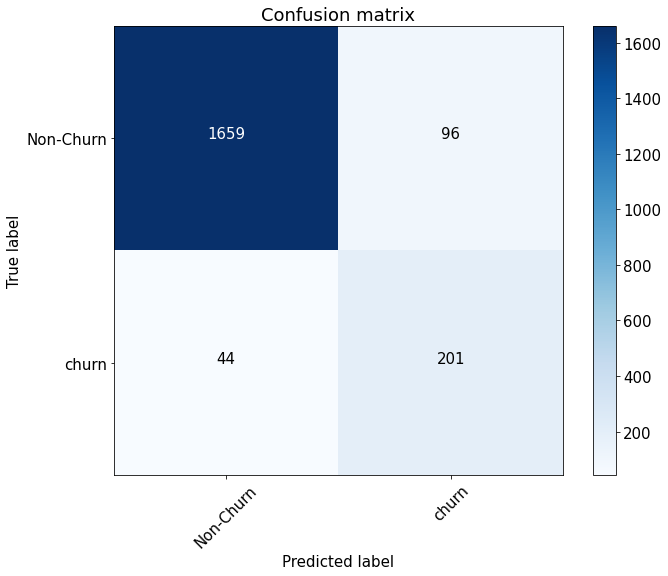

In [54]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'], title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [92]:
roc_auc_median = roc_auc_score(y_test, preds)

In [93]:
total_df = pd.DataFrame(
    [['median', roc_auc_median , fscore[ix] , precision[ix], recall[ix] ]],
    columns=['embadding', 'ROC AUC', 'f1', 'precision', 'recall'])
total_df

,embadding,ROC AUC,f1,precision,recall
0,median,0.970184,0.744015,0.677852,0.82449


# MAX

In [73]:
def get_user_embedding_max(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    #user_vector = np.mean(user_vector, 0)
    user_vector = np.max(user_vector, 0)
    return user_vector

In [94]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_max(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]

X = pd.merge(user_embeddings, target, 'left')

X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

logreg.fit(X_train, y_train)

preds = logreg.predict_proba(X_test)[:, 1]

precision_max, recall_max, thresholds_max = precision_recall_curve(y_test, preds)
fscore_max = (2 * precision_max * recall_max) / (precision_max + recall_max)
# locate the index of the largest f score
ix = np.argmax(fscore_max)

roc_auc_max = roc_auc_score(y_test, preds)

In [111]:
total_df = total_df.append({'embadding':'max', 
                 'ROC AUC':roc_auc_max , 
                 'f1':fscore_max[ix] , 
                 'precision': precision_max[ix], 
                 'recall':recall_max[ix] } , ignore_index=True)
total_df

,embadding,ROC AUC,f1,precision,recall
0,median,0.970184,0.744015,0.677852,0.824490
1,max,0.983150,0.723842,0.624260,0.861224


# MEAN

In [113]:
def get_user_embedding_mean(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
#     user_vector = np.max(user_vector, 0)
    return user_vector

In [114]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_mean(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]

X = pd.merge(user_embeddings, target, 'left')

X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

logreg.fit(X_train, y_train)

preds = logreg.predict_proba(X_test)[:, 1]

precision_mean, recall_mean, thresholds_mean = precision_recall_curve(y_test, preds)
fscore_mean = (2 * precision_mean * recall_mean) / (precision_mean + recall_mean)
# locate the index of the largest f score
ix = np.argmax(fscore_mean)

roc_auc_mean = roc_auc_score(y_test, preds)

In [117]:
#total_df = 
total_df.append({'embadding':'mean', 
                 'ROC AUC':roc_auc_mean , 
                 'f1':fscore_mean[ix] , 
                 'precision': precision_mean[ix], 
                 'recall':recall_mean[ix] } , ignore_index=True)
# total_df

,embadding,ROC AUC,f1,precision,recall
0,median,0.970184,0.744015,0.677852,0.824490
1,max,0.983150,0.723842,0.624260,0.861224
2,mean,0.950255,0.701613,0.693227,0.710204
